# Toy Example - Deep prior

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import elicit as el

from bayesflow.inference_networks import InvertibleNetwork

tfd = tfp.distributions

ModuleNotFoundError: No module named 'tensorflow_probability'

## The Model
### Generative model
\begin{align*}
    (\beta_0, \beta_1, \sigma) &\sim p_\lambda(\boldsymbol{\theta}) \\
    \mu &= \beta_0 + \beta_1X \\
    y_{pred} &\sim \text{Normal}(\mu, \sigma)
\end{align*}

### Implementation

#### Generative model

In [23]:
class ToyModel:
    def __call__(self, prior_samples, design_matrix):
        # linear predictor 
        epred=tf.matmul(prior_samples[:, :, :-1], design_matrix, 
                        transpose_b=True)
        
        # data-generating model
        likelihood = tfd.Normal(
            loc=epred, scale=tf.expand_dims(prior_samples[:, :, -1], -1)
        )
        # prior predictive distribution 
        ypred = likelihood.sample()
        
        # selected observations
        y_x0, y_x1, y_x2, y_x3, y_x4 = (ypred[:,:,i] for i in range(5))

        # R2 
        var_ypred = tf.math.reduce_variance(ypred, -1)
        var_epred = tf.math.reduce_variance(epred, -1)
        r2 = tf.math.divide(var_ypred, tf.add(var_ypred, var_epred))

        return dict(
            y_x0=y_x0, y_x1=y_x1, y_x2=y_x2, y_x3=y_x3, y_x4=y_x4,
            r2=r2
        )

#### Define design matrix

In [24]:
# create a predictor ranging from 1 to 200 
# standardize predictor
# select the 5th, 25th, 50th, 75th, and 95th quantile of the std. predictor for querying the expert
def x_design(n, quantiles):
    x = tf.cast(np.arange(n), tf.float32)
    x_std = (x-tf.reduce_mean(x))/tf.math.reduce_std(x)
    x_sel = tfp.stats.percentile(x_std, quantiles)
    return tf.stack([tf.ones(x_sel.shape), x_sel], -1)

x_design(n=200, quantiles=[5,25,50,75,95])

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 1.        , -1.5502049 ],
       [ 1.        , -0.85737586],
       [ 1.        ,  0.00866036],
       [ 1.        ,  0.85737586],
       [ 1.        ,  1.5502049 ]], dtype=float32)>

#### Model input for elicit method

In [25]:
# specify the model
model=el.model(
        obj=ToyModel,
        design_matrix=x_design(n=200, quantiles=[5,25,50,75,95])
        )

### Model parameters
+ intercept parameter $\beta_0$
+ slope parameter $\beta_1$
+ error term $\sigma$

**To be learned hyperparameters**
$\lambda$: reflecting the weights of the deep neural networks within the normalizing flow architecture.

#### Parameter input for elicit method

In [26]:
parameters=[
        el.parameter(name="beta0"),
        el.parameter(name="beta1"),
        el.parameter(name="sigma", lower=0.)
    ]

## Target quantities and elicitation techniques
**Target quantities**
+ query expert regarding **prior predictions** $y \mid X_{i}$ with $i$ being the 5th, 25th, 50th, 75th, and 95th quantile of the predictor.
+ $R^2 = \frac{\text{Var}(\mu)}{\text{Var}(y)}$ (we use $\log R^2$ for numerical stability)
+ correlation between model parameters

**Elicitation technique**
+ query each prior prediction using **quantile-based elicitation** using $Q_p(y \mid X)$ for $p=5, 25, 50, 75, 95$
+ query $R^2$ using **quantile-based elicitation** using $Q_p(y \mid X)$ for $p=5, 25, 50, 75, 95$
+ regarding the correlation structure, we assume independence between the model parameters (thus, $\boldsymbol{\rho}_\boldsymbol{\theta}=\mathbf{0}$)

**Importance of elicited statistics in loss**
+ all elicited statistics should have equal importance (weight=1.0)
+ for computing the discrepancy between expert-elicited statistics and model simulations with use the Maximum Mean Discrepancy with Energy kernel

#### Targets input for elicit method

In [27]:
targets=[
        el.target(
            name=f"y_x{i}",
            query=el.queries.quantiles((.05, .25, .50, .75, .95)),
            loss=el.losses.MMD2(kernel="energy"),
            weight=1.0
        ) for i in range(5)
        ]+[
        el.target(
            name="r2",
            query=el.queries.quantiles((.05, .25, .50, .75, .95)),
            loss=el.losses.MMD2(kernel="energy"),
            weight=1.0
        ),
        el.target(
            name="correlation",
            query=el.queries.correlation(),
            loss=el.losses.L2,
            weight=0.1
        )
    ]

## Expert elicitation

+ instead of querying a "real" expert, we define a ground truth (i.e., oracle) and simulate the oracle-elicited statistics

#### Expert input for elicit method (here: oracle)

In [28]:
# specify ground truth
ground_truth = {
    "beta0": tfd.Normal(loc=5, scale=1),
    "beta1": tfd.Normal(loc=2, scale=2),
    "sigma": tfd.HalfNormal(scale=5.0),
}

# define oracle
expert=el.expert.simulator(
        ground_truth = ground_truth,
        num_samples = 10_000
    )

## Normalizing Flow
ToDo

In [29]:
network=el.networks.NF(
        inference_network=InvertibleNetwork,
        network_specs=dict(
            num_params=3,
            num_coupling_layers=3,
            coupling_design="affine",
            coupling_settings={
                "dropout": False,
                "dense_args": {
                    "units": 128,
                    "activation": "relu",
                    "kernel_regularizer": None,
                },
                "num_dense": 2,
            },
            permutation="fixed"
        ),
        base_distribution=el.networks.base_normal
    )

## Training: Learn prior distributions based on expert data

**All inputs for elicit method**

In [30]:
eliobj = el.Elicit(
    model=model,
    parameters=parameters,
    targets=targets,
    expert=expert,
    optimizer=el.optimizer(
        optimizer=tf.keras.optimizers.Adam,
        learning_rate=0.001,
        clipnorm=1.0
        ),
    trainer=el.trainer(
        method="deep_prior",
        seed=4,
        epochs=500
    ),
    network=network
)

**Run multiple chains**

In [31]:
# run method
eliobj.fit(parallel=el.utils.parallel(chains=4))

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

## Results
### Convergence

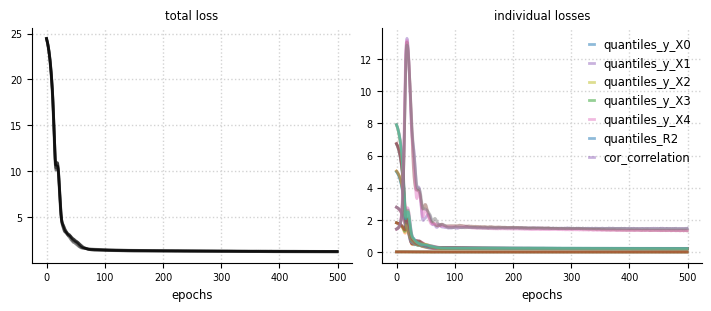

In [12]:
el.plots.loss(eliobj, figsize=(7,3))

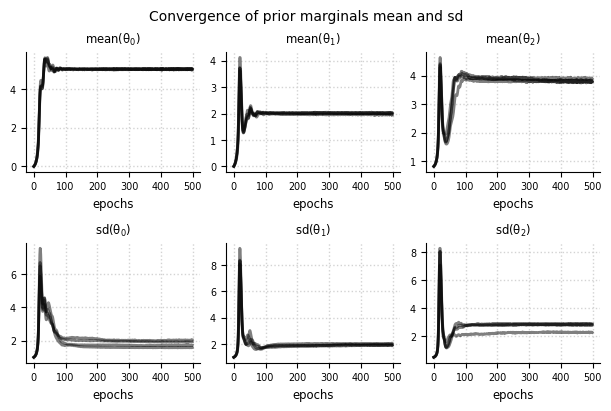

In [14]:
el.plots.marginals(eliobj, cols=3, figsize=(6,4))

### Expert expectations

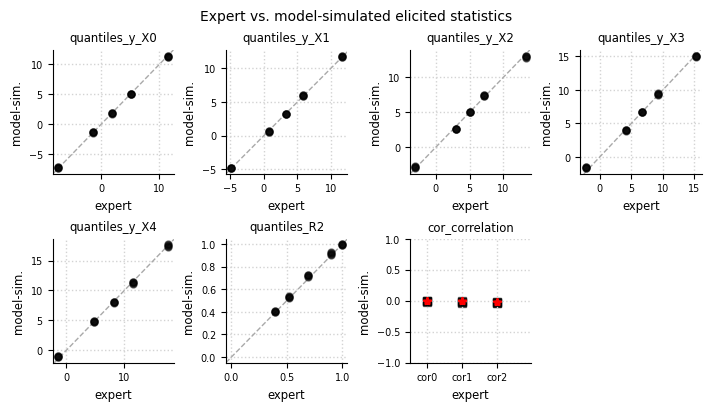

In [16]:
el.plots.elicits(eliobj, cols=4,figsize=(7,4))

### Learned joint prior

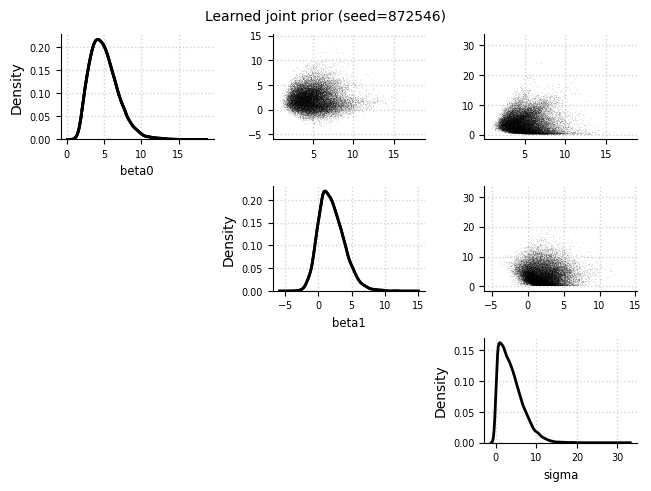

In [19]:
el.plots.prior_joint(eliobj, idx=2)

INFO: Reset cols=3 (number of elicited statistics)


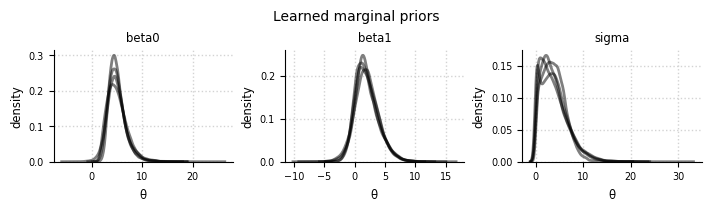

In [20]:
el.plots.prior_marginals(eliobj, figsize=(7,2))

INFO: Reset cols=3 (number of elicited statistics)


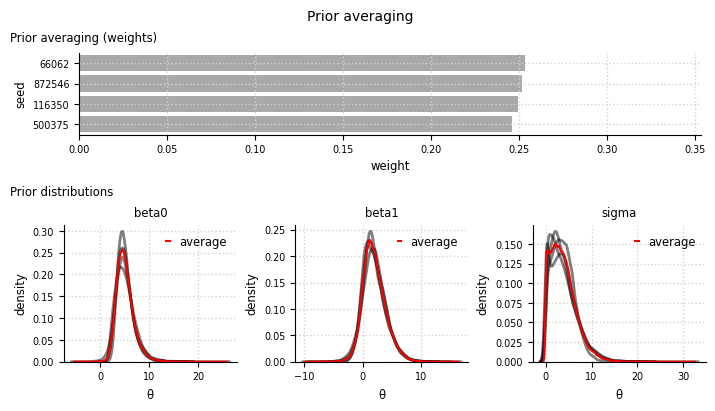

In [22]:
el.plots.prior_averaging(eliobj, figsize=(7,4))

## Add-on: Model averaging

ToDo